# Noise suppression

Very simplified noise suppression algorithm to show how to use the CMSIS-DSP Python wrapper and how it can help translating a float algorithm to a fixed point one ready to be implemented on a Cortex-M or Cortex-A processor.

The CMSIS-DSP package must first be installed. This command will take some time to execute since the CMSIS-DSP will be built.

In [ ]:
!pip install cmsisdsp

The packages required for this example must be loaded:

In [214]:
# Numerical packages
import cmsisdsp as dsp 
import cmsisdsp.fixedpoint as fix
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal.windows import hann

# Package for plotting
import matplotlib.pyplot as plt

# Package to display Audio widget in the notebook and to upload sound files
import ipywidgets
from ipywidgets import FileUpload
from IPython.display import display,Audio

# To convert sound file to NumPy array
import io
import soundfile as sf

# To load test pattern from Arm VHT Echo Canceller demo
from urllib.request import urlopen


## Loading the audio file

You can either upload a .wav file or download the test pattern used in our echo canceller demo running on Arm Virtual Hardware.

It has to be a mono sound at 16 kHz.

### Test pattern from Arm Virtual Hardware demo

This is based on the Yes/No pattern from the TensorFlow Lite Microspeech demo but with added noise and a sequence of Yes/No which is different.

In [216]:
test_pattern_url="https://github.com/ARM-software/VHT-SystemModeling/blob/main/EchoCanceller/sounds/yesno.wav?raw=true"
f = urlopen(test_pattern_url)
filedata = f.read()

### Wav file

Select a .wav file to upload

In [58]:
uploader=FileUpload(accept='wav',multiple=False)
display(uploader)

FileUpload(value={}, accept='wav', description='Upload')

The two next cell is loading the audio data from the uploaded file

In [59]:
filename=list(uploader.value.keys())[0]
filedata=uploader.value[filename]["content"]

### Audio player

You can now listen to the sound to check it is available in this notebook.

In [217]:
audio=Audio(data=filedata,autoplay=False)
audio

A NumPy array is created from the audio and a Q15 and Q31 versions are created.

In [218]:
data, samplerate = sf.read(io.BytesIO(filedata))
data = data + np.random.randn(len(data))*0.00
dataQ15 = fix.toQ15(data)
dataQ31 = fix.toQ31(data)

The audio waveform is plotted

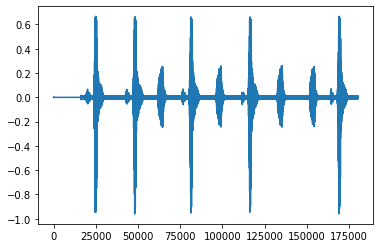

In [219]:
plt.plot(data)
plt.show()

The audio is split into overlapping windows. Those windows will be used in the notebook to implement the processing.
The signal will be rebuilt at the end with an overlap and add

In [155]:
winDuration=30e-3
winOverlap=15e-3
winLength=int(np.floor(samplerate*winDuration))
winOverlap=int(np.floor(samplerate*winOverlap))
slices=sliding_window_view(data,winLength)[::winOverlap,:]
slices_q15=sliding_window_view(dataQ15,winLength)[::winOverlap,:]
slices_q31=sliding_window_view(dataQ31,winLength)[::winOverlap,:]

## Energy VAD

This is a very simplified VAD algorithm based on energy threshold. 

### Double implementation

In [64]:
# Energy of the window
def signal_energy(window):
    w = window - np.mean(window)
    return(10*np.log10(np.sum(window * window)))
    
# Comparison with a threshold
def signal_vad(window):
    if signal_energy(window)>-5:
        return(1)
    else:
        return(0)

Plotting of the signal and the VAD detection. It can be used to tune the threshold for the audio signal used in the notebook. It is unlikely that only one threshold will work with any audio signal. It is a very simplified VAD.

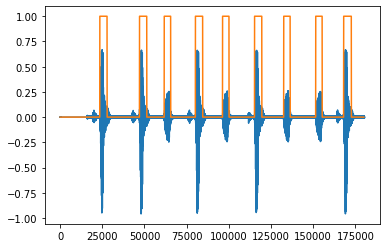

In [65]:
_,ax=plt.subplots(1,1)
vad = np.array([[signal_vad(w)]*winOverlap for w in slices]).flatten()
vad_energy = np.array([[signal_energy(w)]*winOverlap for w in slices]).flatten()
ax.plot(data)
ax.plot(vad)
#ax.plot(vad_energy)

### CMSIS-DSP Q15 implementation

The same functions but in q15 and using CMSIS-DSP API.

In [66]:
def signal_energy_q15(window):
    mean=dsp.arm_mean_q15(window)
    window=dsp.arm_offset_q15(window,-mean)
    energy=dsp.arm_power_q15(window)
    # Energy is not in q15 (refer to CMSIS-DSP documentation)
    energy=dsp.ssat(energy>>20,16)
    # The shift is by more than 15, so the result is not in q15
    # (With a shift smaller there is a saturation)
    dB=dsp.arm_vlog_q15([energy])
    # The output of the vlog is not in q15
    # The multiplication by 10 is missing.
    # The result of this function is not "equal" to the float implementation due to the different
    # formats used in the intermediate computations.
    return(dB[0])
    
def signal_vad_q15(window):
    # The threshold is not easily related to the float implementation because
    # of the different intermediate formats used in the fixed poitn implementation
    if signal_energy_q15(window)>fix.toQ15(-0.26):
        return(1)
    else:
        return(0)

Plot of the signal and VAD which can be used to tune the threshdold. The threshold is different because we do not apply the multiplication by 10 and because the output format of the vlog is not Q15. And the output format of the power function is also not q15 (the formats are described in CMSIS-DSP documentation)

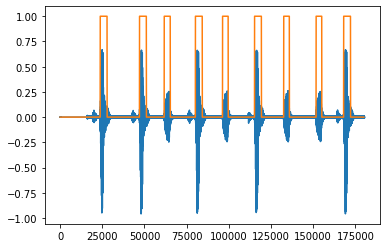

In [67]:
_,ax=plt.subplots(1,1)
#vad = np.array([[signal_vad(w)]*winOverlap for w in slices]).flatten()
vad_q15 = np.array([[signal_vad_q15(w)]*winOverlap for w in slices_q15]).flatten()
ax.plot(data)
#ax.plot(vad)
ax.plot(vad_q15)

### CMSIS-DSP Q31 Implementation

In [179]:
def signal_energy_q31(window):
    mean=dsp.arm_mean_q31(window)
    window=dsp.arm_offset_q31(window,-mean)
    energy=dsp.arm_power_q31(window)
    # Energy is not in q31 (refer to CMSIS-DSP documentation)
    # If the scaling is not enough the int conversion will fail.
    energy=int(energy>>24)
    # The shift is by more than 17, so the result is not in q31
    # (With a shift smaller there is a saturation and int conversion is failing)
    dB=dsp.arm_vlog_q31([energy])
    # The output of the vlog is not in q15
    # The multiplication by 10 is missing.
    # The result of this function is not "equal" to the float implementation due to the different
    # formats used in the intermediate computations.
    return(dB[0])
    
def signal_vad_q31(window):
    # The threshold is not easily related to the float implementation because
    # of the different intermediate formats used in the fixed poitn implementation
    if signal_energy_q31(window)>fix.toQ31(-0.18):
        return(1)
    else:
        return(0)

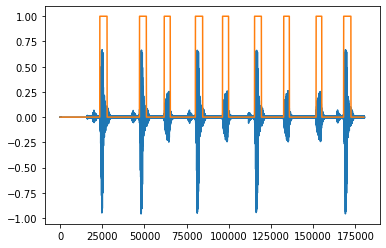

In [180]:
_,ax=plt.subplots(1,1)
#vad = np.array([[signal_vad(w)]*winOverlap for w in slices]).flatten()
vad_q31 = np.array([[signal_vad_q31(w)]*winOverlap for w in slices_q31]).flatten()
ax.plot(data)
#ax.plot(vad)
ax.plot(vad_q31)

## Noise suppression

Each window of samples extracted from the signal is multiplied by a Hann window in below algorithms.

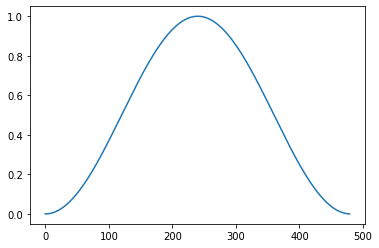

In [68]:
window=hann(winLength,sym=False)
plt.plot(window)
plt.show()

### Double reference implementation

Test of the overlap and add:

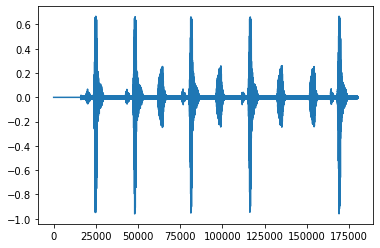

In [69]:
# Overlap and add
offsets = range(0, len(data),winOverlap)
offsets=offsets[0:len(slices)]
res=np.zeros(len(data))
i=0
for n in offsets:
    res[n:n+winLength] += slices[i]*window
    i=i+1
plt.plot(res)
plt.show()

In [70]:
audio2=Audio(data=res,rate=samplerate,autoplay=False)
audio2

#### Reference noise suppression algorithm 

In [86]:
class NoiseSuppression():
    def __init__(self,slices):
        # In a better version this could be computed from the signal length by taking the
        # smaller power of two greater than the signal length.
        self._fftLen=512
        self._signal=[]
        self._slices=slices
        # Compute the vad signal
        self._vad= np.array([signal_vad(w) for w in slices])
        self._windowLength=len(slices[0])
        self._noise=np.zeros(self._fftLen)
        # The Hann window
        self._window=hann(self._windowLength,sym=False)
        
    # Subtract the noise
    def subnoise(self,v):
        # This is a Wiener estimate
        energy = v * np.conj(v) + 1e-6
        scaling = (energy - self._noise)/energy
        scaling[scaling<0] = 0
        
        return(v * scaling)
    
    def remove_noise(self,w):
        # We pad the signal with zero. It assumes that the padding can be divided by 2.
        # In a better implementation we would manage also the odd case.
        # The padding is required because the FFT has a length which is greater than the length of
        # the window
        pad=(self._fftLen-len(w))//2 
        w = w*self._window
        sig=np.hstack([np.zeros(pad),w,np.zeros(pad)])
        # FFT
        fft=np.fft.fft(sig)
        # Noise suppression
        fft = self.subnoise(fft)
        # IFFT
        res=np.fft.ifft(fft)
        # We assume the result should be real so we just ignore the imaginary part
        res=np.real(res)
        # We remove the padding
        res=res[pad:pad+self._windowLength]
        return(res)
    
   
    
    def estimate_noise(self,w):
        # Compute the padded signal
        pad=(self._fftLen-len(w))//2 
        w = w*self._window
        sig=np.hstack([np.zeros(pad),w,np.zeros(pad)])
        fft=np.fft.fft(sig)
        
        # Estimate the noise energy
        self._noise = np.abs(fft)*np.abs(fft)
        
        # Remove the noise
        fft = self.subnoise(fft)
        
        # IFFT and we assume the result is real so we ignore imaginary part
        res=np.fft.ifft(fft)
        res=np.real(res)
        res=res[pad:pad+self._windowLength]
        return(res)
        
    # Process all the windows using the VAD detection
    def nr(self):
        for (w,v) in zip(self._slices,self._vad):
            result=None
            if v==1:
                # If voice detected, we only remove the noise
                result=self.remove_noise(w)
            else:
                # If no voice detected, we update the noise estimate
                result=self.estimate_noise(w)
            self._signal.append(result)
        
    # Overlap and add to rebuild the signal
    def overlap_and_add(self):
        offsets = range(0, len(self._signal)*winOverlap,winOverlap)
        offsets=offsets[0:len(self._signal)]
        res=np.zeros(len(data))
        i=0
        for n in offsets:
            res[n:n+winLength]+=self._signal[i]
            i=i+1
        return(res)
    

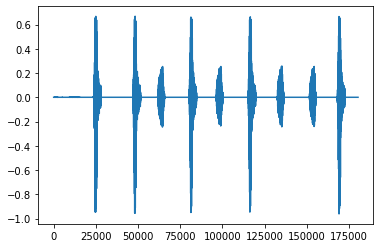

In [87]:
n=NoiseSuppression(slices)
n.nr()
cleaned=n.overlap_and_add()
plt.plot(cleaned)
plt.show()

The audio to check the result:

In [220]:
audioRef=Audio(data=cleaned,rate=samplerate,autoplay=False)
audioRef

### CMSIS-DSP Implementations

Test of the overlap and add. The Hann window is converted to Q15. The CMSIS-DSP functions are not used for this conversions because it is assumed that this conversion is done outside of CMSIS-DSP and the final code (Python or C) is using an array of Q15 values.

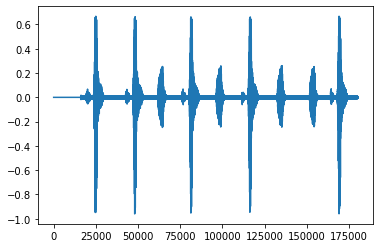

In [74]:
offsets = range(0, len(data),winOverlap)
offsets=offsets[0:len(slices_q15)]
res=np.zeros(len(data))
window_q15=fix.toQ15(window)
i=0
for n in offsets:
    w = dsp.arm_mult_q15(slices_q15[i],window_q15)
    res[n:n+winLength] = dsp.arm_add_q15(res[n:n+winLength],w)
    i=i+1
res_q15=fix.Q15toF32(res)
plt.plot(res_q15)
plt.show()

In [75]:
audio4=Audio(data=res_q15,rate=samplerate,autoplay=False)
audio4

Utilities functions since there is no specific datatype for complex in CMSIS-DSP. An array of complex is thus represented as an array of reals (of twice the number of samples).

In [76]:
def imToReal1D(a):
    ar=np.zeros(np.array(a.shape) * 2)
    ar[0::2]=a.real
    ar[1::2]=a.imag
    return(ar)

def realToIm1D(ar):
    return(ar[0::2] + 1j * ar[1::2])

#### CMSIS-DSP F32 noise suppression algorithm

In [151]:
class NoiseSuppressionF32():
    def __init__(self,slices):
        self._fftLen=512
        self._signal=[]
        self._slices=slices
        # VAD signal
        self._vad= np.array([signal_vad(w) for w in slices])
        self._windowLength=len(slices[0])
        self._noise=np.zeros(self._fftLen,dtype=np.float32)
        # The Hann window
        self._window=hann(self._windowLength,sym=False)
        # CFTT F32 instance
        self._cfftF32=dsp.arm_cfft_instance_f32()
        status=dsp.arm_cfft_init_f32(self._cfftF32,self._fftLen)
        
    
    # Subtract the noise
    def subnoise(self,v):
        energy = dsp.arm_cmplx_mag_squared_f32(v)
        # To avoid division by zeros
        energy = dsp.arm_offset_f32(energy,1e-6)
        
        temp = dsp.arm_sub_f32(energy , self._noise)
        # C implementation will have to loop on the array and replace negative vaues
        temp[temp<0]=0
            
        scaling = np.zeros(len(temp),dtype=np.float32)
        # C implementation will have to loop on the arrays here
        scaling = temp / energy
        
        res=dsp.arm_cmplx_mult_real_f32(v,scaling)    
                    
        return(res)
    
    def remove_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_f32(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.float32),w,np.zeros(pad,dtype=np.float32)])
        
        # Convert real signal to complex        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        
        resultR = dsp.arm_cfft_f32(self._cfftF32,signalR,0,1)
        
        # Remove the noise
        resultR = self.subnoise(resultR)

        # Inverse FFT and we keep only the real part
        res = dsp.arm_cfft_f32(self._cfftF32,resultR,1,1)*self._fftLen
        res=res[0::2]
        # Remove the padding
        res=res[pad:pad+self._windowLength]
        return(res)
    
    def estimate_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_q15(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.float32),w,np.zeros(pad,dtype=np.float32)])
        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        
        resultR = dsp.arm_cfft_f32(self._cfftF32,signalR,0,1)

        self._noise = dsp.arm_cmplx_mag_squared_f32(resultR)
        
        # Set noise to zero. In reference code we substract the noise.
        # It is giving the same result with the noise estimation used.
        resultR = np.zeros(len(resultR),dtype=np.float32)
        
        # Not really needed since we set the values to zero. We could
        # just set the output to zero.
        # But in a more compelx algorithm we may still need to do the IFFT
        # so the line is kept.
        res = dsp.arm_cfft_f32(self._cfftF32,resultR,1,1)*self._fftLen
        
        res=res[0::2]
        res=res[pad:pad+self._windowLength]
        return(res)
        
    def nr(self):
        for (w,v) in zip(self._slices,self._vad):
            result=None
            if v==1:
                result=self.remove_noise(w)
            else:
                result=self.estimate_noise(w)
            self._signal.append(result)
        
    def overlap_and_add(self):
        nbSamples = len(self._signal)*winOverlap
        offsets = range(0, nbSamples,winOverlap)
        offsets=offsets[0:len(self._signal)]
        res=np.zeros(nbSamples)
        i=0
        for n in offsets:
            res[n:n+winLength] = dsp.arm_add_f32(res[n:n+winLength],self._signal[i])
            i=i+1
        return(res)
    

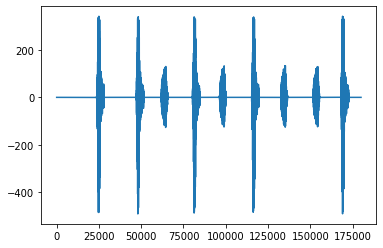

In [152]:
n=NoiseSuppressionF32(slices)
n.nr()
cleaned_f32=n.overlap_and_add()
plt.plot(cleaned_f32)
plt.show()

In [153]:
audioF32=Audio(data=cleaned_f32,rate=samplerate,autoplay=False)
audioF32

#### CMSIS-DSP Q31 noise suppression algorithm

In [183]:
class NoiseSuppressionQ31():
    def __init__(self,slices):
        self._fftLen=512
        self._signal=[]
        self._slices=slices
        # VAD signal
        self._vad= np.array([signal_vad_q31(w) for w in slices])
        self._windowLength=len(slices[0])
        self._noise=np.zeros(self._fftLen,dtype=np.int32)
        # Q31 version of the Hann window
        self._window=fix.toQ31(hann(self._windowLength,sym=False))
        # CFTT Q31 instance
        self._cfftQ31=dsp.arm_cfft_instance_q31()
        status=dsp.arm_cfft_init_q31(self._cfftQ31,self._fftLen)
        
    
    # Subtract the noise
    def subnoise(self,v):
        
        energy = dsp.arm_cmplx_mag_squared_q31(v)
        
        temp = dsp.arm_sub_q31(energy , self._noise)
        temp[temp<0]=0
        
        # Used for computing the division (energy - noise) / energy
        scalingQ31 = np.zeros(len(temp),dtype=np.int32)
        shift = np.zeros(len(temp),dtype=np.int32)
        
        # The scaling factor (energy - noise) / energy is computed
        k=0
        # We assume that |energy-noise|<=energy
        # otherwise we set scaling to 1
        # If energy is 0 we also set scaling to 1
        # When a == b shiftVal is equal to 1 because 1 is represented 
        # as 0x4000 and shift of 1 instead of 0x7FFF for output of division
        # We manage this case separately
        for a,b in zip(temp,energy):
            quotient=0x7FFF
            shiftVal=0
            if b!=0 and a!=b:
                # We compute the quotient
                status,quotient,shiftVal = dsp.arm_divide_q31(a,b)
                if shiftVal > 0:
                    quotient=0x7FFF
                    shiftVal = 0
        
            scalingQ31[k] = quotient
            shift[k] = shiftVal
            
            k = k + 1
        
       
        # We scale the values
        res=dsp.arm_cmplx_mult_real_q31(v,scalingQ31)    
            
        return(res)
    
    def remove_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_q31(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.int32),w,np.zeros(pad,dtype=np.int32)])
        
        # Convert to complex        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        

        resultR = dsp.arm_cfft_q31(self._cfftQ31,signalR,0,1)
        
        resultR = self.subnoise(resultR)

        res = dsp.arm_cfft_q31(self._cfftQ31,resultR,1,1)*self._fftLen
        res=res[0::2]
        res=res[pad:pad+self._windowLength]
        return(res)
    
    def estimate_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_q31(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.int32),w,np.zeros(pad,dtype=np.int32)])
        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        
        resultR = dsp.arm_cfft_q31(self._cfftQ31,signalR,0,1)

        self._noise = dsp.arm_cmplx_mag_squared_q31(resultR)
        
        resultR = np.zeros(len(resultR),dtype=np.int32)
        
        res = dsp.arm_cfft_q31(self._cfftQ31,resultR,1,1)*self._fftLen
        
        res=res[0::2]
        res=res[pad:pad+self._windowLength]
        return(res)
        
    def nr(self):
        for (w,v) in zip(self._slices,self._vad):
            result=None
            if v==1:
                result=self.remove_noise(w)
            else:
                result=self.estimate_noise(w)
            self._signal.append(result)
        
    def overlap_and_add(self):
        nbSamples = len(self._signal)*winOverlap
        offsets = range(0, nbSamples,winOverlap)
        offsets=offsets[0:len(self._signal)]
        res=np.zeros(nbSamples)
        i=0
        for n in offsets:
            res[n:n+winLength] = dsp.arm_add_q31(res[n:n+winLength],self._signal[i])
            i=i+1
        return(res)

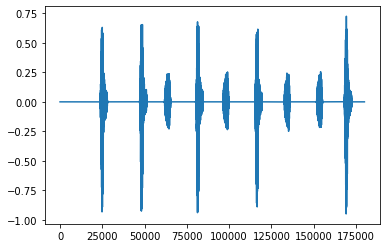

In [184]:
n=NoiseSuppressionQ31(slices_q31)
n.nr()
cleaned_q31=n.overlap_and_add()
plt.plot(fix.Q31toF32(cleaned_q31))
plt.show()

In [185]:
audioQ31=Audio(data=fix.Q31toF32(cleaned_q31),rate=samplerate,autoplay=False)
audioQ31

#### CMSIS-DSP Q15 noise suppression algorithm

In [206]:
class NoiseSuppressionQ15():
    def __init__(self,slices):
        self._fftLen=512
        self._signal=[]
        self._slices=slices
        # VAD signal
        self._vad= np.array([signal_vad_q15(w) for w in slices])
        self._windowLength=len(slices[0])
        self._noise=np.zeros(self._fftLen,dtype=np.int32)
        # Q15 version of the Hann window
        self._window=fix.toQ15(hann(self._windowLength,sym=False))
        # CFTT Q15 instance
        self._cfftQ15=dsp.arm_cfft_instance_q15()
        status=dsp.arm_cfft_init_q15(self._cfftQ15,self._fftLen)
        
    
    # Subtract the noise
    def subnoise(self,v):
        
        # We cannot compute the energy in Q15 because otherwise lots of values are 0.
        # The noise signal is too small for its energy to be representable in Q15.
        # So, we convert into Q31 and do noise subtraction in Q31
        vq31 = dsp.arm_q15_to_q31(v)
        energy = dsp.arm_cmplx_mag_squared_q31(vq31)
        
        temp = dsp.arm_sub_q31(energy , self._noise)
        temp[temp<0]=0
        
        scalingQ31 = np.zeros(len(temp),dtype=np.int32)
        shift = np.zeros(len(temp),dtype=np.int32)
        
        # The scaling factor (energy - noise) / energy is computed
        k=0
        # We assume that |energy-noise|<=energy
        # otherwise we set scaling to 1
        # If energy is 0 we also set scaling to 1
        # When a == b shiftVal is equal to 1 because 1 is represented 
        # as 0x4000 and shift of 1 instead of 0x7FFF for output of division
        # We manage this case separately
        for a,b in zip(temp,energy):
            quotient=0x7FFF
            shiftVal=0
            if b!=0 and a!=b:
                # We compute the quotient
                status,quotient,shiftVal = dsp.arm_divide_q31(a,b)
                if shiftVal > 0:
                    quotient=0x7FFF
                    shiftVal = 0
        
            scalingQ31[k] = quotient
            shift[k] = shiftVal
            
            k = k + 1
        
       
        res=dsp.arm_cmplx_mult_real_q31(vq31,scalingQ31)    
        resQ15 = dsp.arm_q31_to_q15(res)
            
        return(resQ15)
    
    def remove_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_q15(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.int16),w,np.zeros(pad,dtype=np.int16)])
        
        # Convert to complex        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        

        resultR = dsp.arm_cfft_q15(self._cfftQ15,signalR,0,1)
        
        resultR = self.subnoise(resultR)

        res = dsp.arm_cfft_q15(self._cfftQ15,resultR,1,1)*self._fftLen
        res=res[0::2]
        res=res[pad:pad+self._windowLength]
        return(res)
    
    def estimate_noise(self,w):
        pad=(self._fftLen-len(w))//2 
        w = dsp.arm_mult_q15(w,self._window)
        sig=np.hstack([np.zeros(pad,dtype=np.int16),w,np.zeros(pad,dtype=np.int16)])
        
        signalR=np.zeros(len(sig) * 2)
        signalR[0::2]=sig
        
        resultR = dsp.arm_cfft_q15(self._cfftQ15,signalR,0,1)

        resultRQ31 = dsp.arm_q15_to_q31(resultR)
        
        
        self._noise = dsp.arm_cmplx_mag_squared_q31(resultRQ31)
        
        resultR = np.zeros(len(resultR),dtype=np.int16)
        
        res = dsp.arm_cfft_q31(self._cfftQ15,resultR,1,1)*self._fftLen
        
        res=res[0::2]
        res=res[pad:pad+self._windowLength]
        return(res)
        
    def nr(self):
        for (w,v) in zip(self._slices,self._vad):
            result=None
            if v==1:
                result=self.remove_noise(w)
            else:
                result=self.estimate_noise(w)
            self._signal.append(result)
        
    def overlap_and_add(self):
        nbSamples = len(self._signal)*winOverlap
        offsets = range(0, nbSamples,winOverlap)
        offsets=offsets[0:len(self._signal)]
        res=np.zeros(nbSamples)
        i=0
        for n in offsets:
            res[n:n+winLength] = dsp.arm_add_q15(res[n:n+winLength],self._signal[i])
            i=i+1
        return(res)
    

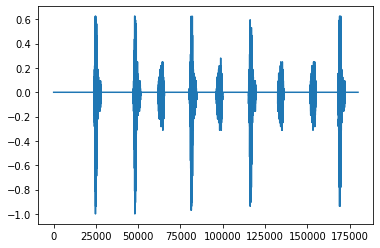

In [207]:
n=NoiseSuppressionQ15(slices_q15)
n.nr()
cleaned_q15=n.overlap_and_add()
plt.plot(fix.Q15toF32(cleaned_q15))
plt.show()

The audio to check the result:

In [208]:
audioQ15=Audio(data=fix.Q15toF32(cleaned_q15),rate=samplerate,autoplay=False)
audioQ15

The result is not very good compared to the Q31 and F32 version. Probably there is not enough accuracy with the Q15 FFT. A possible strategy may be to rescale the signal before computing the FFT to have a better estimate of the noise.

## C Code

Once the Python code is working, the C code should be easy to write since the API of the CMSIS-DSP Python wrapper is as close as possible to the C one.

For instance, let's look at the F32 noise suppression:

```python
energy = dsp.arm_cmplx_mag_squared_f32(v)
# To avoid division by zeros
energy = dsp.arm_offset_f32(energy,1e-6)
        
temp = dsp.arm_sub_f32(energy , self._noise)
# C implementation will have to loop on the array and replace negative vaues
temp[temp<0]=0
            
scaling = np.zeros(len(temp),dtype=np.float32)
# C implementation will have to loop on the arrays here
scaling = temp / energy
        
res=dsp.arm_cmplx_mult_real_f32(v,scaling) 
```

The C code could be:

```C
float32_t *v,*energy,*noise,*temp,*scaling,*res;

arm_cmplx_mag_squared_f32(v,energy,windowLength);
// To avoid division by zeros
arm_offset_f32(energy,1e-6,energy,windowLength);
        
arm_sub_f32(energy , noise,temp,windowLength);

for(int i=0;i < windowLength; i++)
{
    if (temp[i]<0)
    {
        temp[i]=0;
    }
}
            
for(int i=0;i < windowLength; i++)
{
  scaling[i] = temp[i] / energy[i];
}
        
arm_cmplx_mult_real_f32(v,scaling,res,windowLength) ;
```